Notebook to test how well we can perform differential imaging in the sky frame using
flt images converted into a common frame by astrodrozzle


In [1]:
from astropy.io import fits
from stwcs import updatewcs
import glob, os, shutil
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip


%matplotlib notebook

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet




In [2]:
#Setup the working directory and change into it

wdir = '/user/gennaro/Functional_work/WFC3_persistence/py_progs/short_term_persistence/Test_data/Test_IMA/'
os.chdir(wdir)

<IPython.core.display.Javascript object>


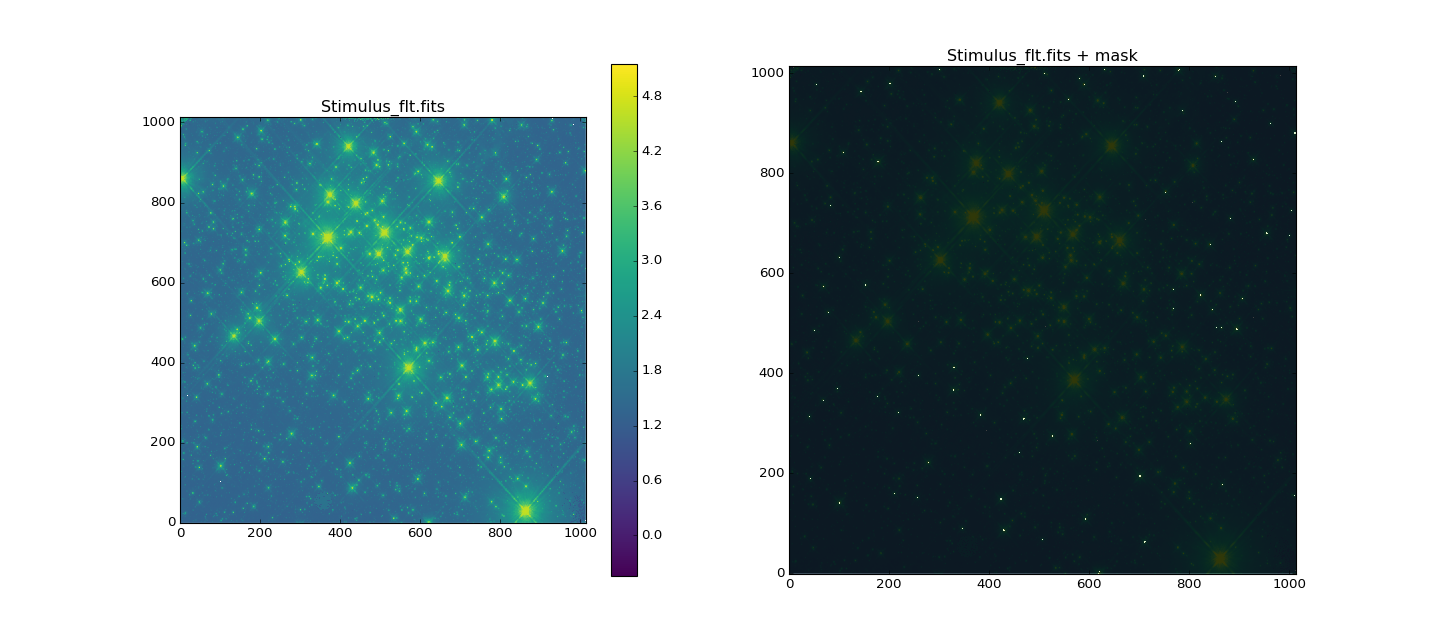

Stimulus_flt.fits F140W 21:32:57 0.0 0.0 352.939514 F140W
-15.6977


/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log10
/Users/gennaro/anaconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in log10


In [3]:
# Print the exposure information for the stimulus image

sfltname = 'Stimulus_flt.fits'
pimaname = 'Persima_ima.fits'
pfltname = 'Persima_flt.fits'

sflt = fits.getdata(sfltname)

fig = plt.figure(figsize=(18,8))

sfhdr0 = fits.getheader(sfltname,0)
sfhdr1 = fits.getheader(sfltname,1)

print(sfltname, sfhdr0['FILTER'], sfhdr0['TIME-OBS'], sfhdr0['POSTARG1'], sfhdr0['POSTARG2'], sfhdr0['EXPTIME'], sfhdr0['FILTER'])
    
ax1 = fig.add_subplot(1,2,1)
c, low, upp = sigmaclip(sflt, 2.5,3)
mn = np.amin(c)
print(mn)
im = ax1.imshow(np.log10(sflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax1.set_title(sfltname)
fig.colorbar(im, ax=ax1)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(np.log10(sflt-mn),cmap='viridis', interpolation='none', origin='lower')
ax2.set_title(sfltname+' + mask')


In [4]:
#Select the region in the stimulus image that will be looked at in the IMA image 

mode = 'lev'
pflt = fits.getdata(pfltname)

msky = np.nanmean(sigmaclip(pflt,2.5,2.5)[0])
ssky = np.nanstd(sigmaclip(pflt,2.5,2.5)[0])

if (mode == 'cen'):
    xcen = 29
    ycen = 19
    rad = 2
    ix = np.arange(fhdr1['NAXIS1'])
    iy = np.arange(fhdr1['NAXIS2'])
    ixx,iyy = np.meshgrid(ix,iy)
    igood = (np.abs(ixx-xcen) < rad) & (np.abs(iyy-ycen) < rad)
elif (mode == 'lev'):
    lev_u = np.inf
    lev_d = 1e4
    igood = (sflt > lev_d) & (sflt < lev_u) & (pflt <msky+1*ssky) & (pflt >msky-1*ssky)

print('Number of selected pixels:',np.sum(igood))

#fig = plt.figure(figsize=(10,8))
#ax1 = fig.add_subplot(1,1,1)
ax2.imshow(igood,cmap='gray', interpolation='none',alpha=0.75,origin='lower')



Number of selected pixels: 410


In [5]:
#NSAMP


nsamp = fits.getheader(pfltname)['NSAMP']
pimahdu = fits.open(pimaname)
pflthdu = fits.open(pfltname)
sflthdu = fits.open(sfltname)


ramps = np.zeros([np.sum(igood),nsamp-1])
eramps = np.zeros([np.sum(igood),nsamp-1])
rfits = np.zeros(np.sum(igood))
sfits = np.zeros(np.sum(igood))
mfits = np.zeros(np.sum(igood))
nsky  = np.zeros(np.sum(igood))
ncsky  = np.zeros(np.sum(igood))


nramps = np.sum(igood)
print('Number of ramps',np.sum(igood))

skyrad_o = 10
skyrad_i = 3

times = np.zeros(nsamp-1)
xgrid,ygrid = np.meshgrid( np.arange(pflthdu[1].data.shape[0]) ,np.arange(pflthdu[1].data.shape[1]))

for i in range(nsamp-1):
    edt = pimahdu['ERR',i+1].data[5:-5,5:-5]
    eramps[:,i] = edt[igood]
    times[i] = pimahdu['TIME',i+1].header['PIXVALUE']
    dt = (pimahdu['SCI',i+1].data[5:-5,5:-5]*times[i] -  pimahdu['SCI',i+2].data[5:-5,5:-5]*pimahdu['TIME',i+2].header['PIXVALUE'])/(times[i]-pimahdu['TIME',i+2].header['PIXVALUE'])
    ramps[:,i] = dt[igood]

goodx = xgrid[igood]
goody = ygrid[igood]
    
for j in range(nramps):
    rfits[j] = pflthdu[1].data[igood][j]
    sfits[j] = sflthdu[1].data[igood][j]
    ix = goodx[j]
    iy = goody[j]
    
    dst = np.sqrt((xgrid-ix)**2 + (ygrid-iy)**2)
    msk = (dst<skyrad_o) & (dst > skyrad_i)
#    msk = (np.fabs(xgrid-ix) < skyrad_o) & (np.fabs(ygrid-iy) < skyrad_o)
    skyarr = pflthdu[1].data[msk]
    
#    skyarr = pflthdu[1].data[ix-skyrad_o:ix+skyrad_o,iy-skyrad_o:iy+skyrad_o]
    cskyarr,l,u = sigmaclip(skyarr,2.,2.)
    mfits[j] = np.nanmean(cskyarr)
    nsky[j] = skyarr.size
    ncsky[j] = cskyarr.size
    
isort = np.argsort(sfits)[::-1]

sfits = sfits[isort]
rfits = rfits[isort]
mfits = mfits[isort]
nsky  = nsky[isort]
ncsky  = ncsky[isort]

ramps[:,:]  = ramps[isort,::-1]
eramps[:,:] = eramps[isort,::-1]
times = times[::-1]


Number of ramps 410


In [8]:
ppr = 8

fig = plt.figure(figsize=(25,nramps))
deltat   = np.logspace(np.log10(times[0]+pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']),np.log10(times[-1]+pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']),100)

ax = []
for aa in range(nramps):

    ax.append(fig.add_subplot((nramps+ppr-1)//ppr,ppr,aa+1))
#    ax[-1].errorbar(times[:-1],ramps[aa,:-1],yerr=eramps[aa,:-1],c='r')
    ax[-1].errorbar(times,ramps[aa,:],yerr=eramps[aa,:])
    ax[-1].plot(deltat,6.5*np.exp(-deltat/135)+rfits[aa])
    ax[-1].axhline(mfits[aa],color='r',label='Sky'+'% .2f' %mfits[aa])
    ax[-1].axhline(rfits[aa],color='magenta',label='Flt'+'% .2f' %rfits[aa])
    ax[-1].legend()
    ax[-1].set_title('Pix:('+str(goodx[aa])+','+str(goody[aa])+')'+'\n Stim =  '+'% .1f' % sfits[aa])
#    ax[-1].set_yscale('log')
#    ax[-1].set_xscale('log')
    
    
plt.tight_layout()

<IPython.core.display.Javascript object>

In [7]:
print(times)

[  27.932802   52.933311   77.933823  102.93433   127.93484   152.93536
  177.93588   202.9364    227.93692   252.93744   277.93796   302.93848
  327.939     352.93951 ]


<IPython.core.display.Javascript object>


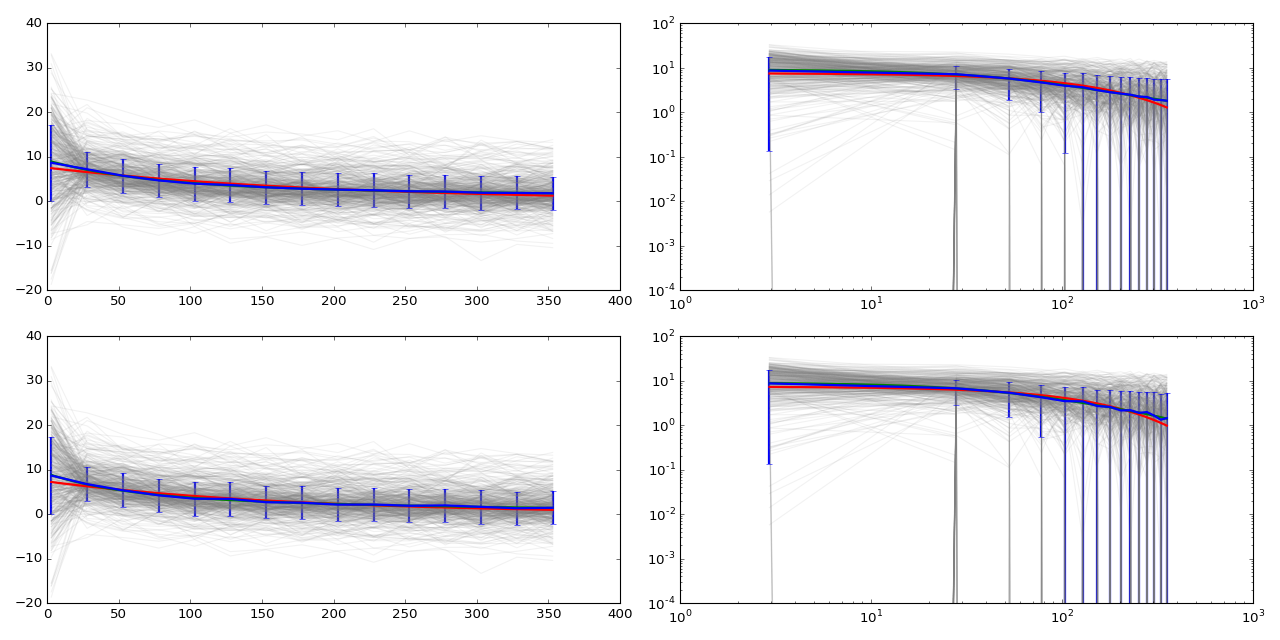

[   7.57492195  199.66755011]
[   7.3525119   175.07493609]
[[  1.26598288e-01  -4.07584917e+00]
 [ -4.07584917e+00   2.11751104e+02]]
[[  1.35961599e-01  -3.71041728e+00]
 [ -3.71041728e+00   1.66381853e+02]]
*********
[   3.34537401  562.76249565    5.88937051   68.03036544]
[   3.90441723  344.42273709    5.23472565   53.22410355]
[[  2.95250571e-01  -8.38526232e+01  -2.45540645e-01  -4.11488876e+00]
 [ -8.38526232e+01   2.42487079e+04   7.07623811e+01   1.13789783e+03]
 [ -2.45540645e-01   7.07623811e+01   2.23998376e-01   3.16206395e+00]
 [ -4.11488876e+00   1.13789783e+03   3.16206395e+00   6.29512619e+01]]
[[  6.43057704e-01  -6.59890620e+01  -5.13810801e-01  -8.26027153e+00]
 [ -6.59890620e+01   6.98157821e+03   5.39080687e+01   8.17024559e+02]
 [ -5.13810801e-01   5.39080687e+01   4.92590610e-01   5.73201863e+00]
 [ -8.26027153e+00   8.17024559e+02   5.73201863e+00   1.21475023e+02]]


In [7]:
fig = plt.figure(figsize=(16,8))

toff = pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND']
#tmod   = np.linspace(times[0],times[-1],100)
#deltat = pflthdu[0].header['EXPSTART'] - sflthdu[0].header['EXPEND'] + tmod
deltat   = np.logspace(np.log10(times[0]+toff),np.log10(times[-1]+toff),100)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

for aa in range(nramps):

    ax1.plot(times,ramps[aa,:]-mfits[aa],c='gray',alpha=.1)
    ax2.plot(times,ramps[aa,:]-mfits[aa],c='gray',alpha=.1)
    ax3.plot(times,ramps[aa,:]-mfits[aa],c='gray',alpha=.1)
    ax4.plot(times,ramps[aa,:]-mfits[aa],c='gray',alpha=.1)

mnp = np.zeros(nsamp-1)
mdp = np.zeros(nsamp-1)
sdp = np.zeros(nsamp-1)

for nn in range(nsamp-1):
    mnp[nn] = np.mean(ramps[:,nn]-mfits)
    mdp[nn] = np.median(ramps[:,nn]-mfits)
    sdp[nn] = np.std(ramps[:,nn]-mfits)
    

def decay1(t,a1,t1):
    e1 = a1*np.exp(-t/t1)
    return e1

def decay2(t,a1,t1,a2,t2):
    e1 = a1*np.exp(-t/t1)
    e2 = a2*np.exp(-t/t2)
    return e1+e2
 
from scipy.optimize import curve_fit

popt1_md, pcov1_md = curve_fit(decay1, times+toff,mdp,sigma=sdp,p0=[4,100])
popt1_mn, pcov1_mn = curve_fit(decay1, times+toff,mnp,sigma=sdp,p0=[4,100])
popt2_md, pcov2_md = curve_fit(decay2, times+toff,mdp,sigma=sdp,p0=[4,100,2,10])
popt2_mn, pcov2_mn = curve_fit(decay2, times+toff,mnp,sigma=sdp,p0=[4,100,2,10])

print(popt1_mn)
print(popt1_md)
print(pcov1_mn)
print(pcov1_md)
print('*********')
print(popt2_mn)
print(popt2_md)
print(pcov2_mn)
print(pcov2_md)

ax1.plot(deltat,decay1(deltat,*popt1_mn),c='r',linewidth=2)
ax2.plot(deltat,decay1(deltat,*popt1_mn),c='r',linewidth=2)
ax3.plot(deltat,decay1(deltat,*popt1_md),c='r',linewidth=2)
ax4.plot(deltat,decay1(deltat,*popt1_md),c='r',linewidth=2)

ax1.plot(deltat,decay2(deltat,*popt2_mn),c='g',linewidth=2)
ax2.plot(deltat,decay2(deltat,*popt2_mn),c='g',linewidth=2)
ax3.plot(deltat,decay2(deltat,*popt2_md),c='g',linewidth=2)
ax4.plot(deltat,decay2(deltat,*popt2_md),c='g',linewidth=2)


ax1.errorbar(times+toff,mnp,yerr=sdp,c='b',linewidth=2)
ax2.errorbar(times+toff,mnp,yerr=sdp,c='b',linewidth=2)
ax3.errorbar(times+toff,mdp,yerr=sdp,c='b',linewidth=2)
ax4.errorbar(times+toff,mdp,yerr=sdp,c='b',linewidth=2)

    
ax2.set_yscale('log')
ax2.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xscale('log')
    
    
plt.tight_layout()

In [124]:

sdp.shape

(15,)